# Metrics


In [4]:
import polars as pl
import torch
from torch import nn

from adl.metrics import stratified_split

pl.Config(tbl_rows=10, float_precision=3)

**Note :** to use this notebook in Google Colab, create a new cell with
the following lines and run it:

```shell
!git clone https://gitlab.in2p3.fr/jbarnier/ateliers_deep_learning.git
%cd ateliers_deep_learning
!pip install .
```

The train and validation losses allow to evaluate the evolution of the
training process, but they are not necessarily good indicators to assess
the quality of the network predictions. For this we need specific
metrics aligned with the problem we are trying to solve.

For example, for a regression problem we could compute the $R^2$ score,
the mean absolute error or the mean absolute percentage error. For a
classification problem we could use many different metrics such as
accuracy, precision, recall, F1-score, ROC AUC, etc.

## Computing metrics during training

In this notebook we will use a dataset on [credit card fraud
detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)
downloaded from Kaggle and converted to a parquet file.


In [5]:
d = pl.read_parquet("data/creditcard.parquet")
d

Class,Amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,149.620,-1.360,-0.073,2.536,1.378,-0.338,0.462,0.240,0.099,0.364,0.091,-0.552,-0.618,-0.991,-0.311,1.468,-0.470,0.208,0.026,0.404,0.251,-0.018,0.278,-0.110,0.067,0.129,-0.189,0.134,-0.021
0,2.690,1.192,0.266,0.166,0.448,0.060,-0.082,-0.079,0.085,-0.255,-0.167,1.613,1.065,0.489,-0.144,0.636,0.464,-0.115,-0.183,-0.146,-0.069,-0.226,-0.639,0.101,-0.340,0.167,0.126,-0.009,0.015
0,378.660,-1.358,-1.340,1.773,0.380,-0.503,1.800,0.791,0.248,-1.515,0.208,0.625,0.066,0.717,-0.166,2.346,-2.890,1.110,-0.121,-2.262,0.525,0.248,0.772,0.909,-0.689,-0.328,-0.139,-0.055,-0.060
0,123.500,-0.966,-0.185,1.793,-0.863,-0.010,1.247,0.238,0.377,-1.387,-0.055,-0.226,0.178,0.508,-0.288,-0.631,-1.060,-0.684,1.966,-1.233,-0.208,-0.108,0.005,-0.190,-1.176,0.647,-0.222,0.063,0.061
0,69.990,-1.158,0.878,1.549,0.403,-0.407,0.096,0.593,-0.271,0.818,0.753,-0.823,0.538,1.346,-1.120,0.175,-0.451,-0.237,-0.038,0.803,0.409,-0.009,0.798,-0.137,0.141,-0.206,0.502,0.219,0.215
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0,0.770,-11.881,10.072,-9.835,-2.067,-5.364,-2.607,-4.918,7.305,1.914,4.356,-1.593,2.712,-0.689,4.627,-0.924,1.108,1.992,0.511,-0.683,1.476,0.213,0.112,1.014,-0.509,1.437,0.250,0.944,0.824
0,24.790,-0.733,-0.055,2.035,-0.739,0.868,1.058,0.024,0.295,0.585,-0.976,-0.150,0.916,1.215,-0.675,1.165,-0.712,-0.026,-1.221,-1.546,0.060,0.214,0.924,0.012,-1.016,-0.607,-0.395,0.068,-0.054
0,67.880,1.920,-0.301,-3.250,-0.558,2.631,3.031,-0.297,0.708,0.432,-0.485,0.412,0.063,-0.184,-0.511,1.329,0.141,0.314,0.396,-0.577,0.001,0.232,0.578,-0.038,0.640,0.266,-0.087,0.004,-0.027


This tabular dataset contains 284 807 rows describing credit card
transactions which happened in september 2013 in Europe:

-   The `Amount` column is the transaction amount
-   The columns `V1` to `V28` are different characteristics of the
    transaction anonymized through a PCA transformation
-   The `Class` column has value 1 if the transaction is a credit card
    fraud, and 0 otherwise

The dataset is highly unbalanced, as there are only 492 fraudulent
transactions.


In [6]:
d.get_column("Class").value_counts()

Class,count
i64,u32
1,492
0,284315


We split this dataset into training and validation data using stratified
sampling to maintain the same proportion of fraudulent transactions in
both datasets. It is necessary because if we sampled randomly we could
get very few of them in the validation set due to their low prevalence.


In [7]:
X_train, X_valid, y_train, y_valid = stratified_split(d, valid_proportion=0.2)

Finally we create a small feed forward neural network and a training
step function as seen previously.


In [8]:
class FraudDetectionNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(29, 10), nn.ReLU(), nn.Linear(10, 10), nn.ReLU(), nn.Linear(10, 2)
        )

    def forward(self, x):
        return self.model(x).squeeze()


def train_step(epoch, model, loss_fn, optimizer):
    # Run training step
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss.backward()
    optimizer.step()
    # Run validation step
    model.eval()
    y_valid_pred = model(X_valid)
    valid_loss = loss_fn(y_valid_pred, y_valid)
    print(f"Epoch: {epoch + 1:2}, loss: {loss:5.3f}, valid_loss: {valid_loss:5.3f}")


We launch a training process using a cross entropy loss, which is more
suitable for a classification problem such as this one.


In [9]:
model = FraudDetectionNetwork()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

epochs = 20
for epoch in range(epochs):
    train_step(epoch, model, loss_fn, optimizer)

Epoch:  1, loss: 0.649, valid_loss: 0.580
Epoch:  2, loss: 0.580, valid_loss: 0.518
Epoch:  3, loss: 0.517, valid_loss: 0.460
Epoch:  4, loss: 0.460, valid_loss: 0.408
Epoch:  5, loss: 0.408, valid_loss: 0.359
Epoch:  6, loss: 0.359, valid_loss: 0.313
Epoch:  7, loss: 0.314, valid_loss: 0.271
Epoch:  8, loss: 0.272, valid_loss: 0.232
Epoch:  9, loss: 0.234, valid_loss: 0.196
Epoch: 10, loss: 0.198, valid_loss: 0.164
Epoch: 11, loss: 0.166, valid_loss: 0.135
Epoch: 12, loss: 0.138, valid_loss: 0.112
Epoch: 13, loss: 0.116, valid_loss: 0.095
Epoch: 14, loss: 0.099, valid_loss: 0.083
Epoch: 15, loss: 0.088, valid_loss: 0.074
Epoch: 16, loss: 0.081, valid_loss: 0.070
Epoch: 17, loss: 0.077, valid_loss: 0.067
Epoch: 18, loss: 0.075, valid_loss: 0.065
Epoch: 19, loss: 0.074, valid_loss: 0.062
Epoch: 20, loss: 0.072, valid_loss: 0.059


The training process seems to go well, both the training and validation
losses seem to go down regularly.

Let’s take a closer look at the predictions of our model on the
validation data. When applying `model` to `X_valid`, we can see that the
result for each observation is a set of two numbers. The first one is
associated to `Class=0`, and the second one to `Class=1`. These values
are not probabilities as they are not numbers between 0 and 1: they are
called _logits_.


In [10]:
logits = model(X_valid)
logits

tensor([[ 5.2758, -4.3871],
        [ 4.0309, -3.6199],
        [12.1061, -9.2236],
        ...,
        [ 5.9372, -5.2991],
        [ 4.5024, -4.0959],
        [10.4529, -8.6524]], grad_fn=<SqueezeBackward0>)

Logits can be converted into probabilites by applying a _softmax_
function to them. But we can also determine the class of each validation
data point by applying `torch.argmax` along the second dimension of our
logits: this will return `0` if the logit associated to `Class=0` is
higher, and `1` otherwise.


In [11]:
classes = torch.argmax(logits, dim=1)
classes


tensor([0, 0, 0,  ..., 0, 0, 0])

So now we can finally look at the number of fraudulent transactions
predicted by our model on our validation dataset.


In [12]:
torch.sum(classes == 1)


tensor(0)

And this value is 0… So our network is learning, as the cross entropy
loss between our logits and the target values is going down, but for the
moment its results are useless.

So if the loss value is useful to assess the progress of our training
process, it is not necessarily a good indicator of the quality of its
results. To evaluate this we need to use other metrics, which will
depend on the problem we want to solve.

**Exercise**

One very simple metric we just computed is the number of fraudulent
transactions identified by the model on the validation dataset. It could
be useful to add this metric to our training process output.

Modify the `train_step` function above to create a new
`train_step_nfraud` method which computes and displays, for each epoch,
the train loss, the validation loss, and the number of predicted
fraudulent transactions in the validation dataset.

Run this new training process for 10 epochs on a new
`FraudDetectionNetwork` model.

We can see that at the start of our training process the model predicts
some fraudulent transactions, but this number goes down to 0 rapidly.

There are many other metrics we can use to assess the results of a
classification problem, and several Python packages provide methods to
compute them more easily. For example, we could use the
`precision_score` and `recall_score` methods of the `scikit-learn`
package to compute precision and recall at each epoch.


In [13]:
from sklearn.metrics import precision_score, recall_score


def train_step_metrics(epoch, model, loss_fn, optimizer):
    # Run training step
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss.backward()
    optimizer.step()

    # Run validation step
    y_valid_pred = model(X_valid)
    valid_loss = loss_fn(y_valid_pred, y_valid)

    # Compute metrics
    pred_classes = torch.argmax(y_valid_pred.detach(), dim=1)
    n_fraud = torch.sum(pred_classes == 1)
    precision = precision_score(y_valid, pred_classes) if n_fraud > 0 else 0
    recall = recall_score(y_valid, pred_classes) if n_fraud > 0 else 0
    print(
        f"Epoch: {epoch + 1:3}, loss: {loss:5.3f}, valid_loss: {valid_loss:5.3f}, n_fraud: {n_fraud:3}, "
        f"precision: {precision:5.3f}, recall: {recall:5.3f}"
    )


model = FraudDetectionNetwork()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

torch.manual_seed(42)
epochs = 10
for epoch in range(epochs):
    train_step_metrics(epoch, model, loss_fn, optimizer)

Epoch:   1, loss: 2.695, valid_loss: 2.271, n_fraud: 56962, precision: 0.002, recall: 1.000
Epoch:   2, loss: 2.254, valid_loss: 1.896, n_fraud: 56962, precision: 0.002, recall: 1.000
Epoch:   3, loss: 1.882, valid_loss: 1.570, n_fraud: 56888, precision: 0.002, recall: 1.000
Epoch:   4, loss: 1.559, valid_loss: 1.262, n_fraud: 56370, precision: 0.002, recall: 1.000
Epoch:   5, loss: 1.255, valid_loss: 0.943, n_fraud: 54516, precision: 0.002, recall: 0.949
Epoch:   6, loss: 0.940, valid_loss: 0.681, n_fraud: 33772, precision: 0.001, recall: 0.378
Epoch:   7, loss: 0.681, valid_loss: 0.564, n_fraud: 6206, precision: 0.000, recall: 0.020
Epoch:   8, loss: 0.563, valid_loss: 0.492, n_fraud:   1, precision: 0.000, recall: 0.000
Epoch:   9, loss: 0.492, valid_loss: 0.440, n_fraud:   0, precision: 0.000, recall: 0.000
Epoch:  10, loss: 0.440, valid_loss: 0.396, n_fraud:   0, precision: 0.000, recall: 0.000


So, the metrics are not good, but the loss is still going down. Maybe we
can look at what happens if we run the training process for longer?


In [14]:
model = FraudDetectionNetwork()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

torch.manual_seed(42)
epochs = 85
for epoch in range(epochs):
    train_step_metrics(epoch, model, loss_fn, optimizer)


Epoch:   1, loss: 0.837, valid_loss: 0.421, n_fraud: 329, precision: 0.088, recall: 0.296
Epoch:   2, loss: 0.420, valid_loss: 0.344, n_fraud:  85, precision: 0.153, recall: 0.133
Epoch:   3, loss: 0.344, valid_loss: 0.302, n_fraud:  20, precision: 0.300, recall: 0.061
Epoch:   4, loss: 0.302, valid_loss: 0.273, n_fraud:   3, precision: 0.000, recall: 0.000
Epoch:   5, loss: 0.274, valid_loss: 0.250, n_fraud:   0, precision: 0.000, recall: 0.000
Epoch:   6, loss: 0.251, valid_loss: 0.231, n_fraud:   0, precision: 0.000, recall: 0.000
Epoch:   7, loss: 0.232, valid_loss: 0.214, n_fraud:   0, precision: 0.000, recall: 0.000
Epoch:   8, loss: 0.216, valid_loss: 0.199, n_fraud:   0, precision: 0.000, recall: 0.000
Epoch:   9, loss: 0.201, valid_loss: 0.186, n_fraud:   0, precision: 0.000, recall: 0.000
Epoch:  10, loss: 0.187, valid_loss: 0.173, n_fraud:   0, precision: 0.000, recall: 0.000
Epoch:  11, loss: 0.175, valid_loss: 0.160, n_fraud:   0, precision: 0.000, recall: 0.000
Epoch:  12

Now we can see that after about 50 epochs, our model starts to predict
fraudulent transactions again, with growing values of precision and
recall. At epoch 85 we get a precision of 0.79 and a recall of 0.80.

## Computing metrics after training

Metrics are useful during training, but they are also very important
post-training, to more accurately assess the results.

For example, we can compute the _confusion matrix_ of our trained model
on our validation dataset by using scikit-learn’s `confusion_matrix`
method.


In [15]:
from sklearn.metrics import confusion_matrix

preds = model(X_valid)
preds = torch.argmax(preds, dim=1)


cm = confusion_matrix(y_valid, preds)
cm


array([[56843,    21],
       [   20,    78]])

Better yet, we can use `ConfusionMatrixDisplay` to generate a much more
readable plot of the confusion matrix.


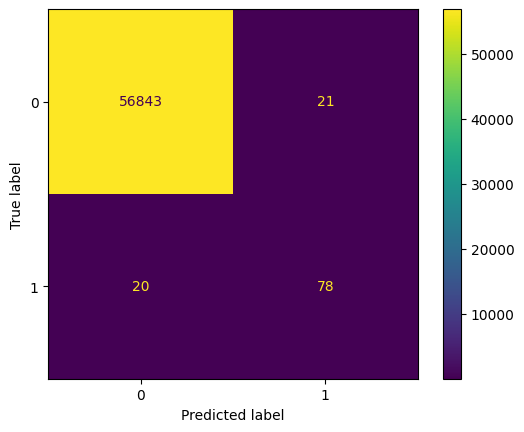

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay(cm).plot()

## Computing metrics when using mini-batches

### Mini-batches training process

Suppose that we are now using mini-batches during our training process,
as seen in the previous notebook: instead of feeding all training or
validation data at once during each training step, we’ll use smaller
subsets of data.

To do this, we first create a `FraudDataset` class and corresponding
`DataLoader` instances for training and validation data, with a batch
size of 256.


In [17]:
class FraudDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.y = y
        self.x = x

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return (self.x[index], self.y[index])


train_dataset = FraudDataset(x=X_train, y=y_train)
valid_dataset = FraudDataset(x=X_valid, y=y_valid)

batch_size = 256
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=False
)


We then define two functions:

-   `train_step` will run a training epoch, _ie_ apply a training step
    to each mini-batches in the training data loader
-   `eval_step` will run a validation epoch, _ie_ apply an evaluation
    step to each mini-batches in the validation data loader


In [18]:
def train_step(model, loss_fn, optimizer):
    # Switch model into train mode
    model.train()
    loss = 0
    for input, target in train_loader:
        # Apply training step to batch
        optimizer.zero_grad()
        pred = model(input)
        batch_loss = loss_fn(pred, target)
        loss += batch_loss
        batch_loss.backward()
        optimizer.step()
    # Compute and return the mean loss for this epoch
    loss /= len(train_loader)
    return loss


def eval_step(model, loss_fn):
    # Switch model into eval mode
    model.eval()
    loss = 0
    for input, target in valid_loader:
        # Apply evaluation step to batch
        pred = model(input)
        batch_loss = loss_fn(pred, target)
        loss += batch_loss
    # Compute and return the mean loss for this epoch
    loss /= len(valid_loader)
    return loss


We can now run our training process on a few epochs.


In [19]:
model = FraudDetectionNetwork()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

epochs = 5
torch.manual_seed(42)
for epoch in range(epochs):
    loss = train_step(model, loss_fn, optimizer)
    valid_loss = eval_step(model, loss_fn)
    print(f"Epoch: {epoch + 1:3}, loss: {loss:5.3f}, valid_loss: {valid_loss:5.3f}")


Epoch:   1, loss: 0.020, valid_loss: 0.004
Epoch:   2, loss: 0.005, valid_loss: 0.004
Epoch:   3, loss: 0.004, valid_loss: 0.004
Epoch:   4, loss: 0.004, valid_loss: 0.004
Epoch:   5, loss: 0.004, valid_loss: 0.004


### Computing a single metric

To add metric computation during this training process with
mini-batches, we can calculate the metric value for each batch. However,
obtaining the overall epoch metric value for the entire validation data
from these mini-batch values can be challenging. Libraries like
`scikit-learn` do not provide methods out of the box to do this, and
manual implementation can be complicated and prone to errors.

A way to do it is to use the `torchmetrics` python package. This package
provides a great number of metrics which can be used directly on a whole
dataset, but can also be applied to mini-batches the following way:

1.  first, we instantiate a metric object from one of `torchmetrics`
    methods. For example, we can use the `BinaryF1Score` class to create
    a `f1_metric` object with `f1_metric = BinaryF1Score()`
2.  at the start of each epoch, we reset the metric with
    `f1_metric.reset()`
3.  for each mini-batch, we update the metric using the mini-batch
    predictions and targets with the `update()` method
4.  finally, at the end of the epoch, we can compute the overall epoch
    metric value using `f1_metric.compute()`

Here is how we can include an F1 metric computation in our evaluation
step by creating a new `eval_step_f1` function.


In [20]:
from torchmetrics.classification import BinaryF1Score

# Instantiate F1 score metric object
f1_metric = BinaryF1Score()


def eval_step_f1(model, loss_fn):
    # Switch model into eval mode
    model.eval()
    # Reset F1 score
    f1_metric.reset()
    loss = 0

    for input, target in valid_loader:
        # Apply evaluation step to batch
        pred = model(input)
        batch_loss = loss_fn(pred, target)
        loss += batch_loss
        # Update metric
        classes_pred = torch.argmax(pred, dim=1)
        f1_metric.update(classes_pred, target)

    # Compute overall loss and metric
    loss /= len(valid_loader)
    f1_score = f1_metric.compute()

    return loss, f1_score


In [21]:
model = FraudDetectionNetwork()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()


epochs = 5
torch.manual_seed(42)

for epoch in range(epochs):
    loss = train_step(model, loss_fn, optimizer)
    valid_loss, valid_f1 = eval_step_f1(model, loss_fn)
    print(
        f"Epoch: {epoch + 1:3}, loss: {loss:5.3f}, valid_loss: {valid_loss:5.3f}, f1: {valid_f1:5.3f}"
    )


Epoch:   1, loss: 0.019, valid_loss: 0.004, f1: 0.772
Epoch:   2, loss: 0.005, valid_loss: 0.005, f1: 0.671
Epoch:   3, loss: 0.004, valid_loss: 0.003, f1: 0.819
Epoch:   4, loss: 0.004, valid_loss: 0.004, f1: 0.802
Epoch:   5, loss: 0.005, valid_loss: 0.004, f1: 0.000


Creating a separate evaluation step function is interesting because it
makes it easy to apply a trained model to a dataset using mini-batches.


In [22]:
eval_step_f1(model, loss_fn)

(tensor(0.0044, grad_fn=<DivBackward0>), tensor(0.))

### Computing a list of metrics

In general we want to compute not just one but multiple metrics. For
instance, we might want to compute the F1-score, precision and recall
values for our classification problem.

`torchmetrics` provides a `MetricCollection` class which allows to do
that quite easily. By passing a list of metrics to `MetricCollection`,
we can create a collection object which will have the same `reset()`,
`update()` and `compute()` methods as single metrics. When used, these
methods will be called for all the metrics in the list.

**Exercise**

Create the following metrics collection object:

```py
from torchmetrics.classification import BinaryF1Score, BinaryPrecision, BinaryRecall
from torchmetrics import MetricCollection

metrics_list = MetricCollection(
    [
        BinaryPrecision(),
        BinaryRecall(),
        BinaryF1Score(),
    ]
)
```

Create a new `eval_step_metrics` function that add these metrics
computation to the evaluation step of our training process and display
their values at the end of each epoch. Run this training process for 10
epochs.
